##Week 4 Materail for ECEN 520L (Prof. Fatemeh Davoudi)


Suppose you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the wisdom of the crowd. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called ensemble learning, and an ensemble learning algorithm is called an ensemble method.

As an example of an ensemble method, you can train a group of decision tree classifiers, each on a different random subset of the training set. You can then obtain the predictions of all the individual trees, and the class that gets the most votes is the ensemble’s prediction. Such an ensemble of decision trees is called a random forest, and despite its simplicity, this is one of the most powerful machine learning algorithms available today.

You will often use ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor. In fact, the winning solutions in machine learning competitions often involve several ensemble methods.

Let's examine the most popular ensemble methods, including voting classifiers, bagging and pasting ensembles, and random forests.

**Voting Classifiers**

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a logistic regression classifier, an SVM classifier, a random forest classifier, a k-nearest neighbors classifier, and perhaps a few more (see following figure). <br>
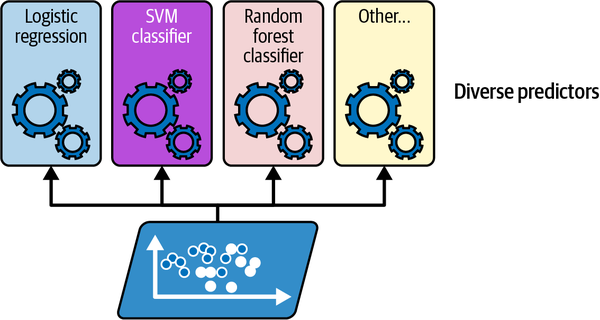

A very simple way to create an even better classifier is to aggregate the predictions of each classifier: the class that gets the most votes is the ensemble’s prediction. This majority-vote classifier is called a hard voting classifier (see following figure). <br>
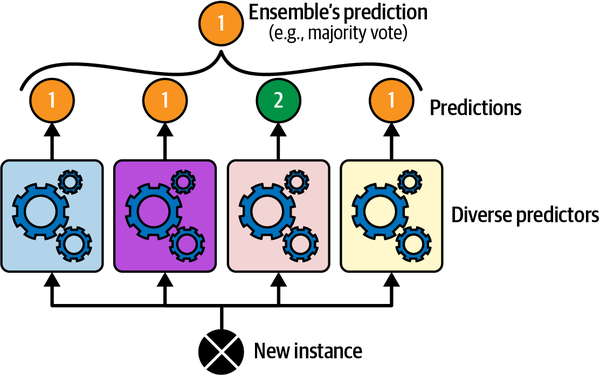

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners in the ensemble and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery. Suppose you have a slightly biased coin that has a 51% chance of coming up heads and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%). Following figure shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%. <br>
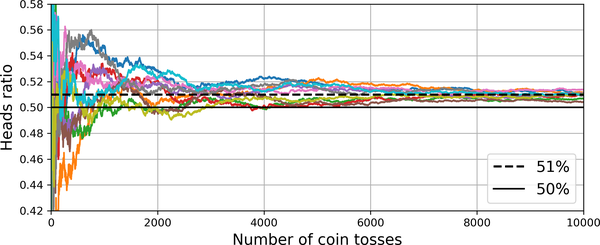

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case because they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

**TIP** <br>
Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

Scikit-Learn provides a VotingClassifier class that’s quite easy to use: just give it a list of name/predictor pairs, and use it like a normal classifier. Let’s try it on the moons dataset. We will load and split the moons dataset into a training set and a test set, then we’ll create and train a voting classifier composed of three diverse classifiers:

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

When you fit a VotingClassifier, it clones every estimator and fits the clones. The original estimators are available via the estimators attribute, while the fitted clones are available via the estimators_ attribute. If you prefer a dict rather than a list, you can use named_estimators or named_estimators_ instead. To begin, let’s look at each fitted classifier’s accuracy on the test set:

In [2]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


When you call the voting classifier’s predict() method, it performs hard voting. For example, the voting classifier predicts class 1 for the first instance of the test set, because two out of three classifiers predict that class:

In [3]:
voting_clf.predict(X_test[:1])

array([1])

In [4]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

Now let’s look at the performance of the voting classifier on the test set:

In [5]:
voting_clf.score(X_test, y_test)

0.912

There you have it! The voting classifier outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities (i.e., if they all have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is set the voting classifier’s voting hyperparameter to "soft", and ensure that all classifiers can estimate class probabilities. This is not the case for the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method). Let’s try that:

In [6]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

We reach 92% accuracy simply by using soft voting—not bad!

**Bagging and Pasting**

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor but train them on different random subsets of the training set. When sampling is performed with replacement (imagine picking a card randomly from a deck of cards, writing it down, then placing it back in the deck before picking the next card: the same card could be sampled multiple times), this method is called bagging (short for bootstrap aggregating (in statistics, resampling with replacement is called bootstrapping)). When sampling is performed without replacement, it is called pasting.

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. This sampling and training process is represented in following figure:<br>
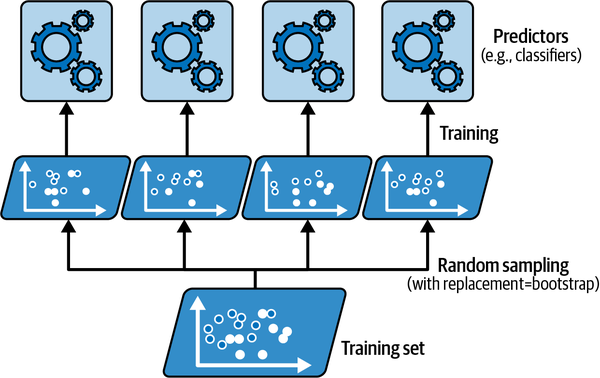

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the statistical mode for classification (i.e., the most frequent prediction, just like with a hard voting classifier), or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

As you can see in previous figure, predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons bagging and pasting are such popular methods: they scale very well.

**Bagging and Pasting in Scikit-Learn**

Scikit-Learn offers a simple API for both bagging and pasting: BaggingClassifier class (or BaggingRegressor for regression). The following code trains an ensemble of 500 decision tree classifiers: each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False). The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions, and –1 tells Scikit-Learn to use all available cores:

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

**NOTE** <br>
A BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with decision tree classifiers.

Following figure compares the decision boundary of a single decision tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset. As you can see, the ensemble’s predictions will likely generalize much better than the single decision tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular). <br>
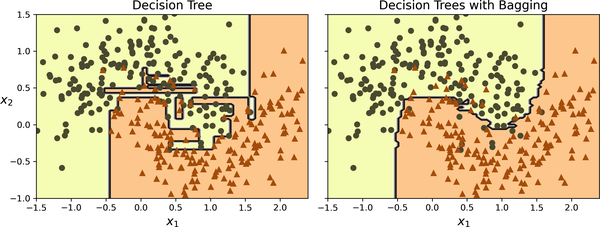

An important theoretical result of statistics and machine learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:


*   **Bias**<br>
This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

*   **Variance**<br>
This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance and thus overfit the training data.
*   **Irreducible error**<br>
This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).


Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a trade-off.



Bagging introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance is reduced. Overall, bagging often results in better models, which explains why it’s generally preferred. But if you have spare time and CPU power, you can use cross-validation to evaluate both bagging and pasting and select the one that works best.

**Out-of-Bag Evaluation**

With bagging, some training instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples m training instances with replacement (bootstrap=True), where m is the size of the training set. With this process, it can be shown mathematically that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called out-of-bag (OOB) instances. Note that they are not the same 37% for all predictors. <br>

If you randomly draw one instance from a dataset of size m, each instance in the dataset obviously has probability 1/m of getting picked, and therefore it has a probability 1 – 1/m of not getting picked. If you draw m instances with replacement, all draws are independent and therefore each instance has a probability (1 – 1/m)m of not getting picked. Now let's use the fact that exp(x) is equal to the limit of (1 + x/m)m as m approaches infinity. So if m is large, the ratio of out-of-bag instances will be about exp(–1) ≈ 0.37. So roughly 63% (1 – 0.37) will be sampled.

In [8]:
# extra code – shows how to compute the 63% proba
import numpy as np

print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


A bagging ensemble can be evaluated using OOB instances, without the need for a separate validation set: indeed, if there are enough estimators, then each instance in the training set will likely be an OOB instance of several estimators, so these estimators can be used to make a fair ensemble prediction for that instance. Once you have a prediction for each instance, you can compute the ensemble’s prediction accuracy (or any other metric). <br>
In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic OOB evaluation after training. The following code demonstrates this. The resulting evaluation score is available in the oob_score_ attribute:

In [9]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

According to this OOB evaluation, this BaggingClassifier is likely to achieve about 89.6% accuracy on the test set. Let’s verify this:

In [10]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

We get 92% accuracy on the test. The OOB evaluation was a bit too pessimistic, just over 2% too low.

The OOB decision function for each training instance is also available through the oob_decision_function_ attribute. Since the base estimator has a predict_proba() method, the decision function returns the class probabilities for each training instance. For example, the OOB evaluation estimates that the first training instance has a 67.6% probability of belonging to the positive class and a 32.4% probability of belonging to the negative class:

In [11]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

**Random Patches and Random Subspaces**

The BaggingClassifier class supports sampling the features as well. Sampling is controlled by two hyperparameters: max_features and bootstrap_features. They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.

This technique is particularly useful when you are dealing with high-dimensional inputs (such as images), as it can considerably speed up training. Sampling both training instances and features is called the random patches method. Keeping all training instances (by setting bootstrap=False and max_samples=1.0) but sampling features (by setting bootstrap_features to True and/or max_features to a value smaller than 1.0) is called the random subspaces method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

**Random Forests**

As we have discussed, a random forest is an ensemble of decision trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set. Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can use the RandomForestClassifier class, which is more convenient and optimized for decision trees (similarly, there is a RandomForestRegressor class for regression tasks). The following code trains a random forest classifier with 500 trees, each limited to maximum 16 leaf nodes, using all available CPU cores:

In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

The random forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. By default, it samples $\sqrt{n}$ features (where n is the total number of features). The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model. So, the following BaggingClassifier is equivalent to the previous RandomForestClassifier:

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [14]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

**Extra-Trees**

When you are growing a tree in a random forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular decision trees do). For this, simply set splitter="random" when creating a DecisionTreeClassifier.

A forest of such extremely random trees is called an extremely randomized trees (or extra-trees for short) ensemble. Once again, this technique trades more bias for a lower variance. It also makes extra-trees classifiers much faster to train than regular random forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

You can create an extra-trees classifier using Scikit-Learn’s ExtraTreesClassifier class. Its API is identical to the RandomForestClassifier class, except bootstrap defaults to False. Similarly, the ExtraTreesRegressor class has the same API as the RandomForestRegressor class, except bootstrap defaults to False.

**TIP** <br>
It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross-validation.

**Feature Importance**

Yet another great quality of random forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result using the feature_importances_ variable. For example, the following code trains a RandomForestClassifier on the iris dataset and outputs each feature’s importance. It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively):

In [15]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Similarly, if you train a random forest classifier on the MNIST dataset and plot each pixel’s importance, you get the image represented in following figure.

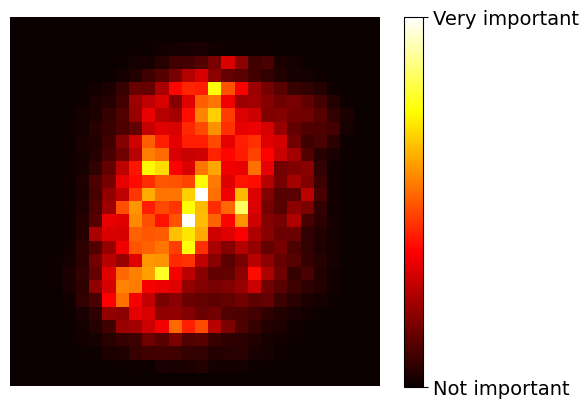

In [16]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

Random forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

In [17]:
from scipy.stats import binom

n = 1000  # tosses
p = 0.51 # probability of head (coin is biased)
x = 501  # to get majority of heads out of 1000 tosses, 501 need to be.
1 - binom.cdf(x-1, n, p)

0.7260985557304961

In [18]:
from scipy.stats import binom

n = 10000  # tosses
p = 0.51 # probability of head (coin is biased)
x = 5001  # to get majority of heads out of 10000 tosses,5001 needs to be.
1 - binom.cdf(x-1, n, p)

0.9767182874807411